In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import lightkurve as lk



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

3573.582275390625 electron / s


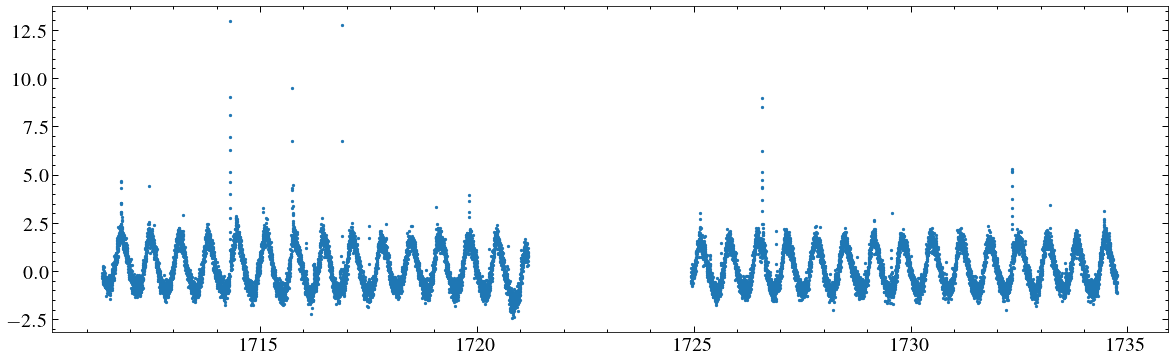

3495.080810546875 electron / s


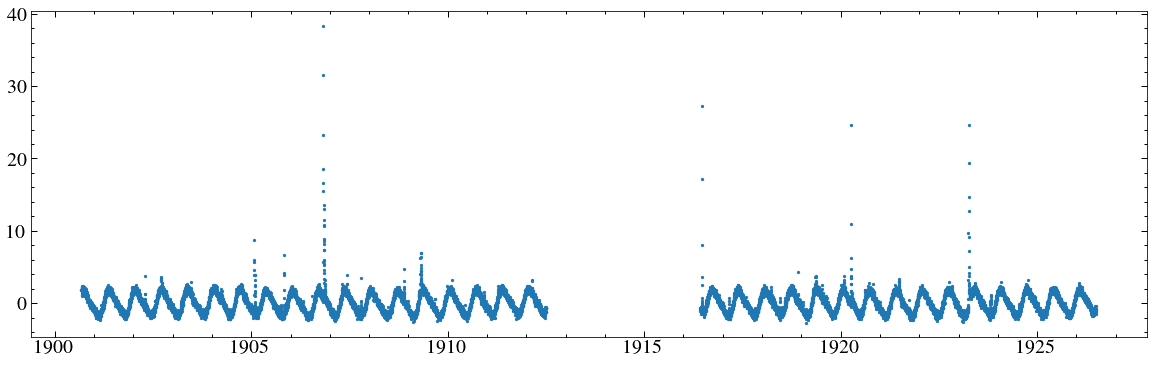

In [2]:
eg_uma_fits= ['/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2019226182529-s0015-0000000416538823-0151-s/tess2019226182529-s0015-0000000416538823-0151-s_lc.fits',
'/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2020049080258-s0022-0000000416538823-0174-s/tess2020049080258-s0022-0000000416538823-0174-s_lc.fits']


fitter = fitting.LevMarLSQFitter()




for tessfits in eg_uma_fits:
    hdul = fits.open(tessfits)
    #data = fits.getdata(tessfits, 1)
    data = hdul[1].data
    hdr = hdul[0].header
 #   print(hdr['RA_OBJ'], hdr['DEC_OBJ'])
    hdul.close()
  #  t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
   # t, f, e = t[q==0], f[q==0], e[q==0]
    lc = lk.read(tessfits)
  #  fit = np.polyval((np.polyfit(t,f,1)), t)
    #f = (f/fit)-1
    #e = (e/fit)-1
    #med = np.median(f)
    #print(med)
   # f = (f/med)-1
   # print(f)
   # e = (e/med)
    plt.figure(figsize=(20, 6))
#     lc = lk.LightCurve(time=t*u.d, flux=f, flux_err=e)#.remove_outliers(sigma=5)#.flatten(window_length=1001).remove_nans()
    lc = lc.remove_nans()
    med = np.median(lc.flux)
    print(med)
    lc.flux /= med
    lc.flux -= 1
    lc.flux  *= 100
    lc.flux_err *= 100
    plt.scatter(lc.time.value,lc.flux, s=5)
    #plt.axhline(med*100, c='C1')
    plt.show()
    
    #plt.subplot(131)

183.933741620044 52.5170250022383
3573.211669921875 electron / s
Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude          frequency            phase       
    ------------------ ------------------ ------------------
    1.3227048958821084 1.4976570296777938 -0.448790865679026
<class 'numpy.ndarray'>
183.933741620044 52.5170250022383
3494.290283203125 electron / s
Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude          frequency           phase       
    ------------------- ----------------- ------------------
    -1.6484615694987355 1.497864930618863 -3.300093763579851
<class 'numpy.ndarray'>


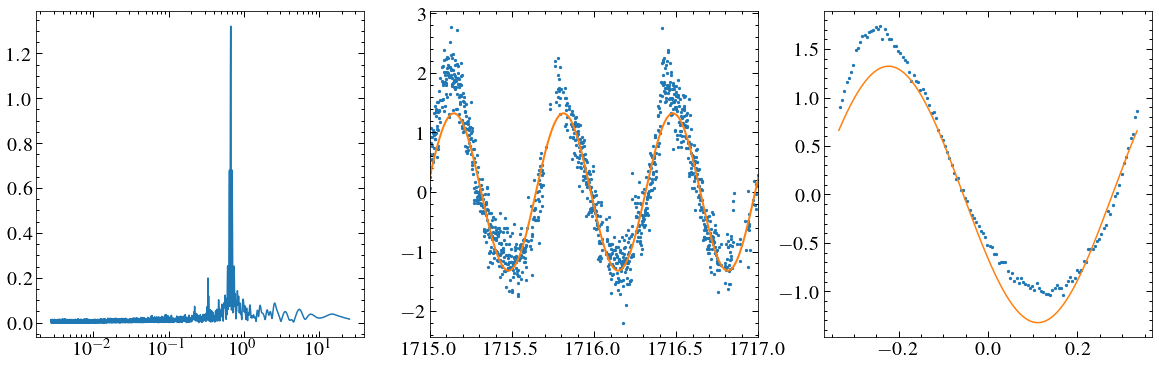

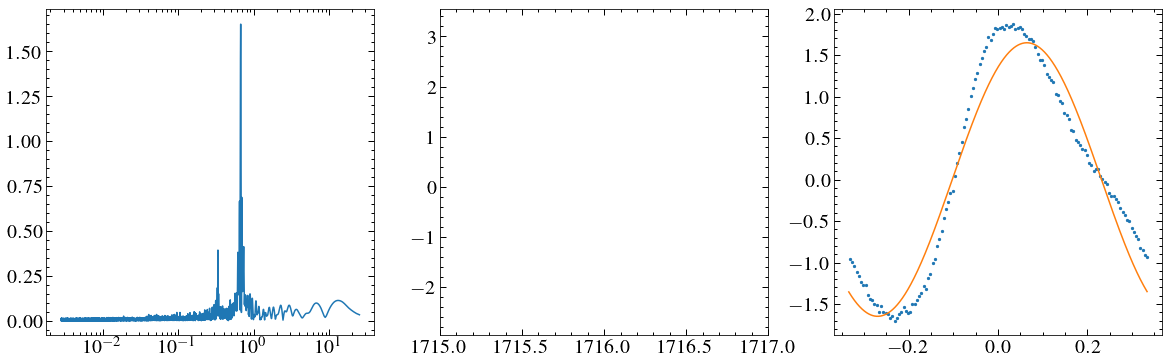

In [64]:
eg_uma_fits= ['/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2019226182529-s0015-0000000416538823-0151-s/tess2019226182529-s0015-0000000416538823-0151-s_lc.fits',
'/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2020049080258-s0022-0000000416538823-0174-s/tess2020049080258-s0022-0000000416538823-0174-s_lc.fits']

preds = ['lc1_preds.npy', 'lc2_preds.npy']
fitter = fitting.LevMarLSQFitter()




for i, tessfits in enumerate(eg_uma_fits):
    hdul = fits.open(tessfits)
    #data = fits.getdata(tessfits, 1)
    data = hdul[1].data
    hdr = hdul[0].header
    print(hdr['RA_OBJ'], hdr['DEC_OBJ'])
    hdul.close()
#     t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
#     t, f, e = t[q==0], f[q==0], e[q==0]  
    lc = lk.read(tessfits).remove_nans()
    flares = np.load(preds[i])
    mask = (flares <0.5)
    lc = lc[mask]
    
    if i == 0: #removing weird bit on end
        mask = (lc.time.value < 1720) | (lc.time.value > 1722)
        lc = lc[mask]
    
    if i == 1: #removing the flare stella missed
        mask = (lc.time.value < 1916.4) | (lc.time.value > 1916.6)
        lc = lc[mask]
    
  #  fit = np.polyval((np.polyfit(t,f,1)), t)
    #f = (f/fit)-1
    #e = (e/fit)-1
 #   med = np.median(f)
   # print(med)
  #  f = (f/med)-1
  #  print(f)
  #  e = (e/med)
    plt.figure(figsize=(20, 6))
#     lc = lk.LightCurve(time=t, flux=f, flux_err=e).remove_outliers(sigma=5).remove_nans()#.flatten(window_length=1001).remove_nans()
    med = np.median(lc.flux)
    print(med)
    lc.flux /= med
#     lc = lc.flatten(3001)
    lc.flux = lc.flux.value
    lc.flux_err = lc.flux_err.value
    lc.flux -= 1
    lc.flux  *= 100
    lc.flux_err *= 100
  
    
    plt.subplot(131)

    
#     mask = (lc.flux <3) #flares 
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=25*u.day)
    plt.plot(pg.period, pg.power)
    plt.xscale('log')
    
    plt.subplot(132)
    plt.scatter(lc.time.value,lc.flux, s=5)
    

    
    sin_mod =  models.Sine1D(amplitude=pg.max_power, frequency= pg.frequency_at_max_power.value) #+ models.Sine1D(amplitude=pg.max_power, frequency= (pg.frequency_at_max_power.value)*2)
    sin_fit = fitter(sin_mod, lc.time.value, lc.flux.value, weights = 1/lc.flux_err.value, maxiter=10000)
    print(sin_fit)
    sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    timefit = np.linspace(lc.time[0].value, lc.time[-1].value, 2000)
#     timefit = np.linspace(1710, 1740, 2000)
    print(type(timefit))
    plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 
    plt.xlim(1715, 1717)
#     print('Period =', (1/sin_fit[0].frequency.value)*24, (sin_fit_e[1]/(sin_fit[0].frequency.value**2))*24, 'h')
#     print('Period2 =', (1/sin_fit[1].frequency.value)*24, (sin_fit_e[4]/(sin_fit[1].frequency.value**2))*24, 'h')
#     print('Amplitude =', sin_fit[0].amplitude.value, sin_fit_e[0])
#     print('Amplitude2 =', sin_fit[1].amplitude.value, sin_fit_e[3])

    

#     print(pg.period_at_max_power.to(u.hour))
    plt.subplot(133)
    lcf = lc.fold(1/sin_fit.frequency).bin(0.005)
    mf = lk.LightCurve(time=timefit, flux=sin_fit(timefit)).fold(1/sin_fit.frequency)
    plt.scatter(lcf.time.value, lcf.flux, s=5)
    plt.plot(mf.time.value, mf.flux, c='C1')
    

15632 15632


15632 15632


(1916.0, 1917.0)

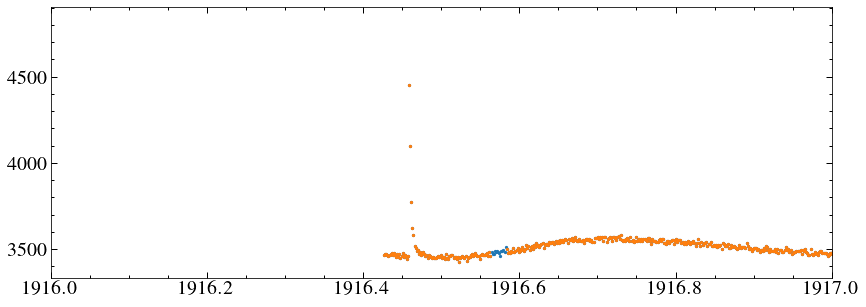

In [42]:
preds2 = np.load('lc2_preds.npy')
lc = lk.read(eg_uma_fits[0]).remove_nans()
print(len(preds2), len(lc))
# plt.scatter(lc.time.value, preds1)
plt.scatter(lc.time.value,lc.flux, s=5)
mask = (preds2 < 0.9)
plt.scatter(lc.time.value[mask],lc.flux[mask], s=5)
plt.xlim(1916, 1917)

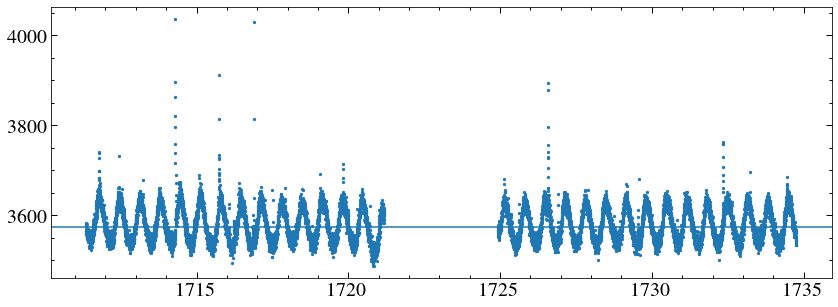

In [62]:
lc = lk.read(eg_uma_fits[0]).remove_nans()
plt.scatter(lc.time.value,lc.flux, s=5)
plt.axhline(np.median(lc.flux.value))

In [66]:
import eb

ModuleNotFoundError: No module named 'eb'